In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [7]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [8]:
model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_embed=[512, 256, 128], 
                      d_quality=[512, 256, 1], 
                      n_heads=1,
                      lbd=1.).to('cuda')

In [9]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)

Epoch 0001 Train MSE 3470.972 Validate MSE 1.023 Raw MSE 0.985
Epoch 0002 Train MSE 3471.004 Validate MSE 1.073 Raw MSE 1.039
Epoch 0003 Train MSE 3470.978 Validate MSE 1.053 Raw MSE 1.019
Epoch 0004 Train MSE 3470.971 Validate MSE 1.062 Raw MSE 1.030
Epoch 0005 Train MSE 3470.988 Validate MSE 1.037 Raw MSE 1.003
Epoch 0006 Train MSE 3470.989 Validate MSE 1.057 Raw MSE 1.029
Epoch 0007 Train MSE 3470.966 Validate MSE 1.030 Raw MSE 1.003
Epoch 0008 Train MSE 3470.981 Validate MSE 1.038 Raw MSE 1.013
Epoch 0009 Train MSE 3470.963 Validate MSE 1.039 Raw MSE 1.014
Epoch 0010 Train MSE 3470.970 Validate MSE 1.024 Raw MSE 1.001
Epoch 0011 Train MSE 3470.966 Validate MSE 1.031 Raw MSE 1.007
Epoch 0012 Train MSE 3470.971 Validate MSE 1.040 Raw MSE 1.015
Epoch 0013 Train MSE 3470.979 Validate MSE 1.038 Raw MSE 1.018
Epoch 0014 Train MSE 3470.969 Validate MSE 1.026 Raw MSE 1.006
Epoch 0015 Train MSE 3470.972 Validate MSE 1.040 Raw MSE 1.024
Epoch 0016 Train MSE 3470.978 Validate MSE 1.020 Raw MS

In [10]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))

Epoch 0501 Train MSE 3470.951 Validate MSE 0.970 Raw MSE 1.001
Epoch 0502 Train MSE 3470.923 Validate MSE 0.966 Raw MSE 1.004
Epoch 0503 Train MSE 3470.898 Validate MSE 0.957 Raw MSE 0.998
Epoch 0504 Train MSE 3470.914 Validate MSE 0.986 Raw MSE 1.033


Epoch 0505 Train MSE 3470.898 Validate MSE 0.926 Raw MSE 0.985
Epoch 0506 Train MSE 3470.904 Validate MSE 0.971 Raw MSE 1.031
Epoch 0507 Train MSE 3470.881 Validate MSE 0.930 Raw MSE 1.000
Epoch 0508 Train MSE 3470.879 Validate MSE 0.952 Raw MSE 1.018
Epoch 0509 Train MSE 3470.896 Validate MSE 0.943 Raw MSE 1.009
Epoch 0510 Train MSE 3470.884 Validate MSE 0.933 Raw MSE 0.994
Epoch 0511 Train MSE 3470.872 Validate MSE 0.972 Raw MSE 1.041
Epoch 0512 Train MSE 3470.869 Validate MSE 0.944 Raw MSE 1.020
Epoch 0513 Train MSE 3470.891 Validate MSE 0.928 Raw MSE 1.005
Epoch 0514 Train MSE 3470.866 Validate MSE 0.947 Raw MSE 1.022
Epoch 0515 Train MSE 3470.871 Validate MSE 0.936 Raw MSE 1.018
Epoch 0516 Train MSE 3470.872 Validate MSE 0.938 Raw MSE 1.020
Epoch 0517 Train MSE 3470.874 Validate MSE 0.909 Raw MSE 0.986
Epoch 0518 Train MSE 3470.879 Validate MSE 0.903 Raw MSE 0.987
Epoch 0519 Train MSE 3470.864 Validate MSE 0.925 Raw MSE 1.004
Epoch 0520 Train MSE 3470.852 Validate MSE 0.921 Raw MS

In [11]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))

Epoch 1001 Train MSE 3463.030 Validate MSE 0.921 Raw MSE 1.024
Epoch 1002 Train MSE 3439.706 Validate MSE 0.886 Raw MSE 0.986
Epoch 1003 Train MSE 3416.472 Validate MSE 0.900 Raw MSE 1.007
Epoch 1004 Train MSE 3393.347 Validate MSE 0.917 Raw MSE 1.047
Epoch 1005 Train MSE 3370.368 Validate MSE 0.919 Raw MSE 1.023


Epoch 1006 Train MSE 3347.437 Validate MSE 0.875 Raw MSE 0.988
Epoch 1007 Train MSE 3324.651 Validate MSE 0.939 Raw MSE 1.047
Epoch 1008 Train MSE 3301.930 Validate MSE 0.892 Raw MSE 1.001
Epoch 1009 Train MSE 3279.321 Validate MSE 0.889 Raw MSE 1.000
Epoch 1010 Train MSE 3256.802 Validate MSE 0.892 Raw MSE 1.015
Epoch 1011 Train MSE 3234.371 Validate MSE 0.917 Raw MSE 1.017
Epoch 1012 Train MSE 3212.027 Validate MSE 0.892 Raw MSE 1.007
Epoch 1013 Train MSE 3189.814 Validate MSE 0.896 Raw MSE 1.008
Epoch 1014 Train MSE 3167.691 Validate MSE 0.908 Raw MSE 1.017
Epoch 1015 Train MSE 3145.658 Validate MSE 0.901 Raw MSE 1.023
Epoch 1016 Train MSE 3123.746 Validate MSE 0.917 Raw MSE 1.037
Epoch 1017 Train MSE 3101.879 Validate MSE 0.936 Raw MSE 1.038
Epoch 1018 Train MSE 3080.176 Validate MSE 0.905 Raw MSE 1.032
Epoch 1019 Train MSE 3058.553 Validate MSE 0.900 Raw MSE 1.006
Epoch 1020 Train MSE 3037.017 Validate MSE 0.916 Raw MSE 1.031
Epoch 1021 Train MSE 3015.612 Validate MSE 0.870 Raw MS

Text(0, 0.5, 'MSE')

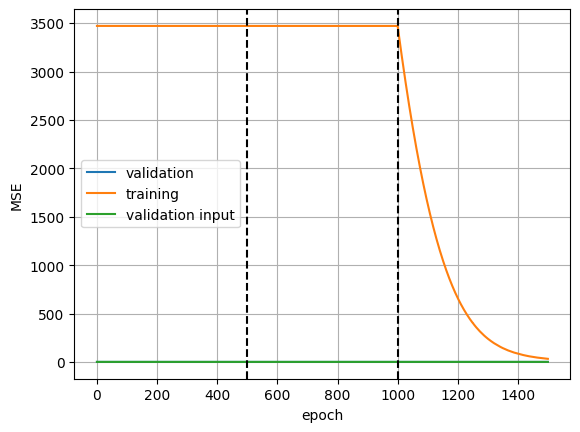

In [12]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [13]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 400 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

,epoch,mse,stage
0,0,1.023116,pre-denoise
1,1,1.072698,pre-denoise
2,2,1.052880,pre-denoise
3,3,1.062477,pre-denoise
4,4,1.037216,pre-denoise
...,...,...,...
1495,1495,0.849001,denoise-smooth-enhance
1496,1496,0.828720,denoise-smooth-enhance
1497,1497,0.863670,denoise-smooth-enhance
1498,1498,0.862343,denoise-smooth-enhance


/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


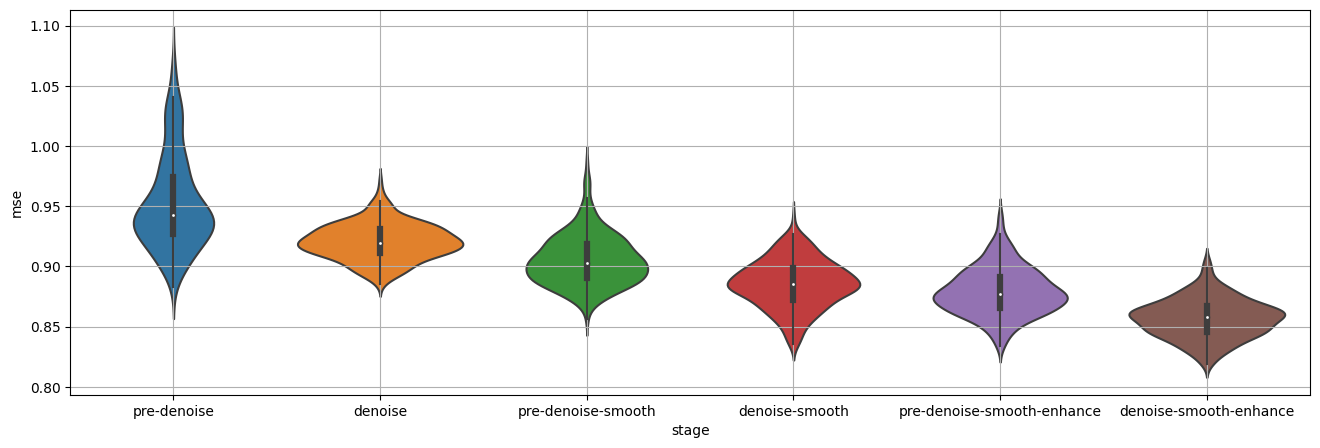

In [14]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [15]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 5.582472284565487e-60 f = 0.922192


In [16]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 6.816343863939999e-46 f = 0.867552


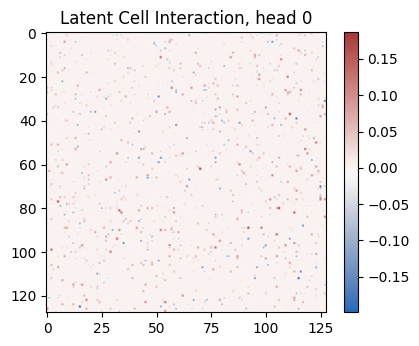

In [17]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()

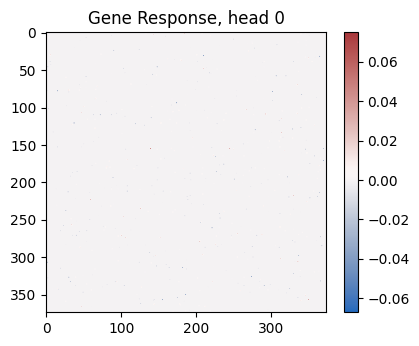

In [18]:
# Plot heatmap of the parameters in gene response module

weight_GRs = []
for head in range(len(model.cell_interacts)):
    weight_GRs.append(model.cell_interacts[head].gene_response.data)

plt.figure(figsize=(10, 8))
for i, weight_GR in enumerate(weight_GRs):
    weight_array = weight_GR.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Gene Response, head {i}')
plt.show()

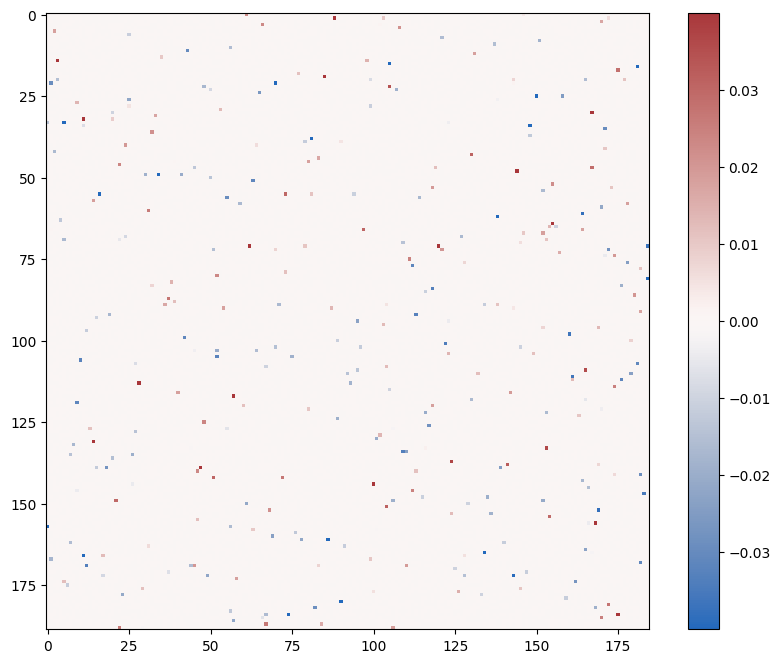

In [19]:
# Extract meaningful weights from Gene Response
THRESHOLD = 0.01

matGR = model.cell_interacts[0].gene_response.data.cpu().numpy()
col_max = np.max(np.abs(matGR), axis=0)
row_max = np.max(np.abs(matGR), axis=1)

meaningfulCols = np.where(col_max > THRESHOLD)[0]
meaningfulRows = np.where(row_max > THRESHOLD)[0]

meaningfulMatGR = matGR[meaningfulRows, :][:, meaningfulCols]

meaningfulMatGR = np.clip(meaningfulMatGR, -.04, .04)

plt.figure(figsize=(10, 8))
plt.imshow(meaningfulMatGR, cmap='vlag')
plt.colorbar()

In [20]:
genesCol = adata.var_names[meaningfulCols]
genesRow = adata.var_names[meaningfulRows]

genesCol, genesRow

(Index(['ENSMUSG00000035783', 'ENSMUSG00000020178', 'ENSMUSG00000024397',
        'ENSMUSG00000036777', 'ENSMUSG00000060802', 'ENSMUSG00000036896',
        'ENSMUSG00000045532', 'ENSMUSG00000028222', 'ENSMUSG00000019997',
        'ENSMUSG00000030724',
        ...
        'ENSMUSG00000046160', 'ENSMUSG00000019880', 'ENSMUSG00000026083',
        'ENSMUSG00000041959', 'ENSMUSG00000025357', 'ENSMUSG00000055761',
        'ENSMUSG00000040612', 'ENSMUSG00000020160', 'ENSMUSG00000050711',
        'ENSMUSG00000097648'],
       dtype='object', length=185),
 Index(['ENSMUSG00000018381', 'ENSMUSG00000035783', 'ENSMUSG00000020178',
        'ENSMUSG00000024397', 'ENSMUSG00000036777', 'ENSMUSG00000038115',
        'ENSMUSG00000037010', 'ENSMUSG00000060802', 'ENSMUSG00000045532',
        'ENSMUSG00000027559',
        ...
        'ENSMUSG00000068117', 'ENSMUSG00000046160', 'ENSMUSG00000024610',
        'ENSMUSG00000034271', 'ENSMUSG00000023868', 'ENSMUSG00000055415',
        'ENSMUSG00000041959', 'ENSM

In [21]:
meaningfulMatGR.shape

(189, 185)

([<matplotlib.axis.YTick at 0x7fe705717f90>,
 [Text(0, 0, 'ENSMUSG00000030209'),
  Text(0, 1, 'ENSMUSG00000034164'),
  Text(0, 2, 'ENSMUSG00000079450'),
  Text(0, 3, 'ENSMUSG00000078354'),
  Text(0, 4, 'ENSMUSG00000034714'),
  Text(0, 5, 'ENSMUSG00000025776'),
  Text(0, 6, 'ENSMUSG00000050121'),
  Text(0, 7, 'ENSMUSG00000038115'),
  Text(0, 8, 'ENSMUSG00000022112'),
  Text(0, 9, 'ENSMUSG00000000290')])

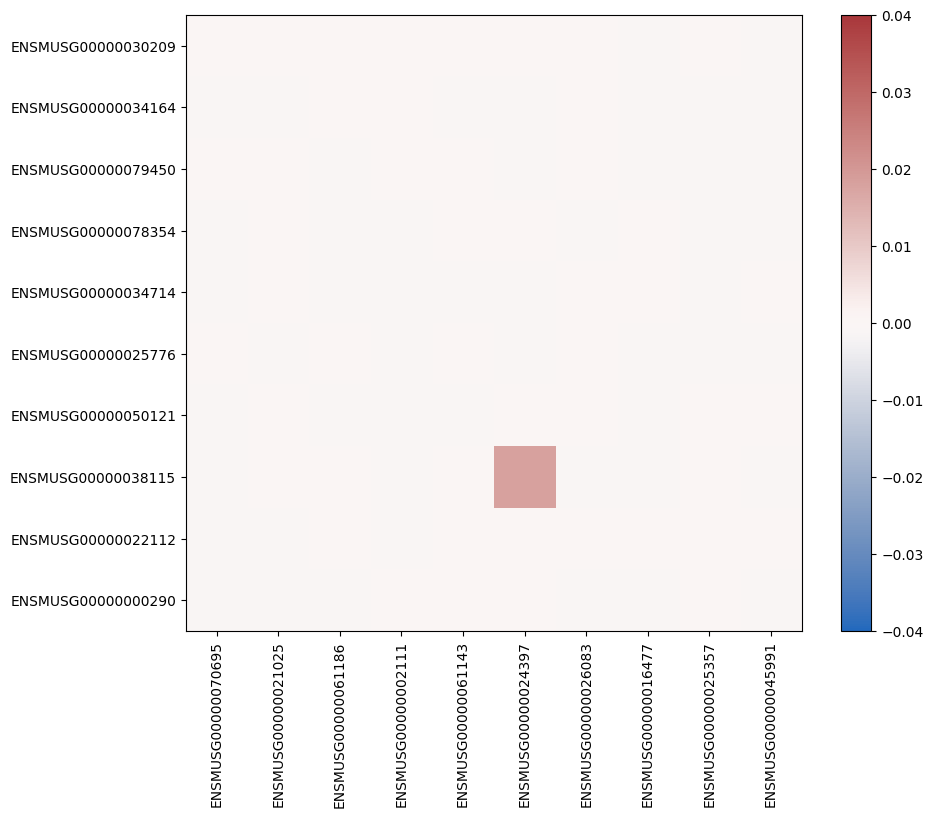

In [22]:
# take out a random patch

PATCH_SIZE = 10

idxCol = np.random.choice(meaningfulMatGR.shape[1], size=PATCH_SIZE, replace=False)
idxRow = np.random.choice(meaningfulMatGR.shape[0], size=PATCH_SIZE, replace=False)

patchMatGR = meaningfulMatGR[idxRow, :][:, idxCol]
patchGeneCol = genesCol[idxCol]
patchGeneRow = genesRow[idxRow]

plt.figure(figsize=(10, 8))
plt.imshow(patchMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
plt.xticks(range(PATCH_SIZE), patchGeneCol, rotation=90)
plt.yticks(range(PATCH_SIZE), patchGeneRow)

In [23]:
# # take out a random column

# randColIdx = np.random.choice(meaningfulMatGR.shape[1], size=1, replace=False)
# randCol = meaningfulMatGR[:, randColIdx]
# randGene = genesCol[randColIdx]
# meaningfulY = np.abs(randCol) > THRESHOLD

# randCol = randCol[meaningfulY]

# randGene = randGene[meaningfulY]

# plt.figure(figsize=(10, 8))
# plt.imshow(randCol, cmap='vlag', vmin=-.04, vmax=.04)
# plt.colorbar()
# plt.xticks(range(1), randGene, rotation=90)
# plt.yticks(range(meaningfulMatGR.shape[0]), genesRow)